<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>


# Deep Learning Basics with PyTorch

**Dr. Yves J. Hilpisch with GPT-5**


# Chapter 10 — Improving Training
Regularization, early stopping, and LR schedules.

## Overview

This notebook provides a concise, hands-on walkthrough of Deep Learning Basics with PyTorch.
Use it as a companion to the chapter: run each cell, read the short notes,
and try small variations to build intuition.

Tips:
- Run cells top to bottom; restart kernel if state gets confusing.
- Prefer small, fast experiments; iterate quickly and observe outputs.
- Keep an eye on shapes, dtypes, and devices when using PyTorch.


In [1]:
# !pip -q install torch numpy matplotlib scikit-learn
import torch, numpy as np, matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
plt.style.use('seaborn-v0_8')  # plotting
%config InlineBackend.figure_format = 'retina'


## Train/val curves with/without weight decay

In [2]:
import torch
import torch.nn.functional as F
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

def curves_l2(weight_decay):
    torch.manual_seed(0)
    X, y = make_moons(n_samples=1000, noise=0.35, random_state=0)
    # small train split to induce overfitting and highlight L2
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X, y, test_size=0.65, random_state=42, stratify=y
    )
    X_va, _, y_va, _ = train_test_split(
    X_tmp, y_tmp, test_size=0.65, random_state=42, stratify=y_tmp
    )
    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    y_tr = torch.tensor(y_tr, dtype=torch.long)
    X_va = torch.tensor(X_va, dtype=torch.float32)
    y_va = torch.tensor(y_va, dtype=torch.long)

    model = torch.nn.Sequential(torch.nn.Linear(2, 256), torch.nn.ReLU(), torch.nn.Linear(256, 2))
    opt = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=weight_decay)
    tr, va = [], []
    for _ in range(150):
        model.train()
        logits = model(X_tr)
        loss = F.cross_entropy(logits, y_tr)
        opt.zero_grad(); loss.backward(); opt.step()
        model.eval()
        with torch.no_grad():
            tr.append(float(loss))
            va.append(float(F.cross_entropy(model(X_va), y_va)))
            return tr, va

            # Compare no L2 vs L2
            tr0, va0 = curves_l2(0.0)
            tr1, va1 = curves_l2(5e-3)

            e = range(1, len(tr0)+1)
            plt.figure(figsize=(7.6, 3.0))
            plt.subplot(1, 2, 1)
            plt.plot(e, tr0, label='train'); plt.plot(e, va0, label='val')
            plt.title('no weight decay'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(frameon=False)
            plt.subplot(1, 2, 2)
            plt.plot(e, tr1, label='train'); plt.plot(e, va1, label='val')
            plt.title('weight decay 0.005'); plt.xlabel('epoch'); plt.legend(frameon=False)
            plt.tight_layout(); plt.show()


## Dropout p=0.0 vs p=0.6 — validation curves

In [3]:
import torch
import torch.nn.functional as F
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

def curves_dropout(p):
    torch.manual_seed(0)
    X, y = make_moons(n_samples=1000, noise=0.40, random_state=0)
    # even smaller train split to surface regularization effect
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X, y, test_size=0.7, random_state=42, stratify=y
    )
    X_va, _, y_va, _ = train_test_split(
    X_tmp, y_tmp, test_size=0.7, random_state=42, stratify=y_tmp
    )
    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    y_tr = torch.tensor(y_tr, dtype=torch.long)
    X_va = torch.tensor(X_va, dtype=torch.float32)
    y_va = torch.tensor(y_va, dtype=torch.long)

    model = torch.nn.Sequential(torch.nn.Linear(2, 256), torch.nn.ReLU(), torch.nn.Dropout(p), torch.nn.Linear(256, 2))
    opt = torch.optim.Adam(model.parameters(), lr=5e-3)
    va = []
    for _ in range(150):
        model.train()
        logits = model(X_tr)
        loss = F.cross_entropy(logits, y_tr)
        opt.zero_grad(); loss.backward(); opt.step()
        model.eval()
        with torch.no_grad():
            va.append(float(F.cross_entropy(model(X_va), y_va)))
            return va

            v0 = curves_dropout(0.0)
            v1 = curves_dropout(0.6)

            e = range(1, len(v0)+1)
            plt.figure(figsize=(5.8, 3.0))
            plt.plot(e, v0, label='dropout p = 0.0')
            plt.plot(e, v1, label='dropout p = 0.6')
            plt.xlabel('epoch'); plt.ylabel('val loss'); plt.legend(frameon=False)
            plt.tight_layout(); plt.show()


## Early stopping (keep best validation model)

In [5]:
import torch
import torch.nn.functional as F

def train_earlystop(X_tr, y_tr, X_va, y_va, *, epochs=200, patience=20):
    model = torch.nn.Sequential(torch.nn.Linear(2, 32), torch.nn.ReLU(), torch.nn.Linear(32, 2))
    opt = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-3)
    loss_fn = torch.nn.CrossEntropyLoss()
    best_sd = None
    best = float('inf')
    wait = 0
    for _ in range(epochs):
        model.train(); opt.zero_grad()
        loss = loss_fn(model(X_tr), y_tr); loss.backward(); opt.step()
        model.eval()
        with torch.no_grad():
            va = float(loss_fn(model(X_va), y_va))
            if va < best:
                best = va
                wait = 0
                best_sd = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            else:
                wait += 1
                if wait >= patience:
                    break
                    if best_sd is not None:
                        model.load_state_dict(best_sd)
                        return model, best


## Learning-rate schedules (constant, step, cosine)

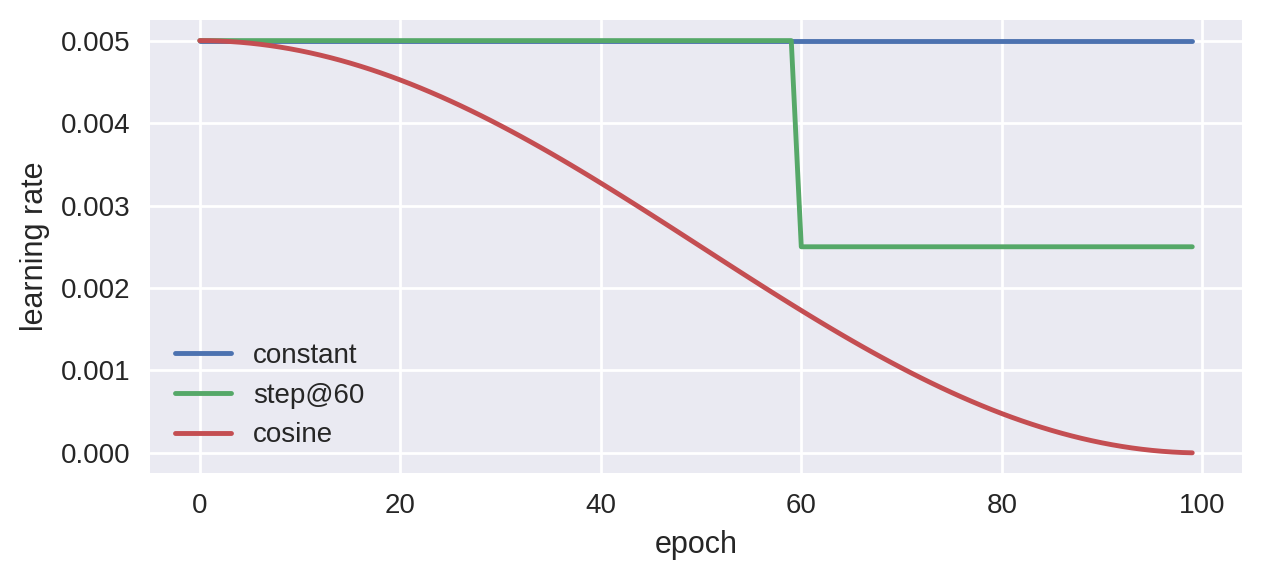

In [6]:
epochs = np.arange(0, 100)
lr_const = np.full_like(epochs, 5e-3, dtype = float)
lr_step = np.where(epochs < 60, 5e-3, 2.5e-3)
lr_cos = 0.5*(1+np.cos(np.pi*epochs/100))*5e-3
plt.figure(figsize = (6.4, 3.0))  # plotting
plt.plot(epochs, lr_const, label = 'constant')  # plotting
plt.plot(epochs, lr_step, label = 'step@60')  # plotting
plt.plot(epochs, lr_cos, label = 'cosine')  # plotting
plt.xlabel('epoch')  # plotting
plt.ylabel('learning rate')  # plotting
plt.legend(frameon = False)  # plotting
plt.tight_layout()  # plotting
plt.show()  # plotting


<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>


## Exercises

1. Compare training with and without weight decay; plot losses and metrics.
2. Try a different LR schedule (e.g., cosine) and discuss stability/performance.
